In [1]:
from scipy.stats import kurtosis, skew

In [2]:
import numpy as np

In [3]:
def conv(s):
    try:
        if s == '':
            return -1
        else:
            x = int(s)
            return x
    except:
        print(s)
        return -1

In [4]:
data = np.loadtxt("completelabel.csv", delimiter=',', skiprows=1, usecols=[0,3,4,5,6],converters={6:conv})

b''


In [5]:
# looks like 8Hz frequency

In [6]:
import matplotlib.pyplot as plt


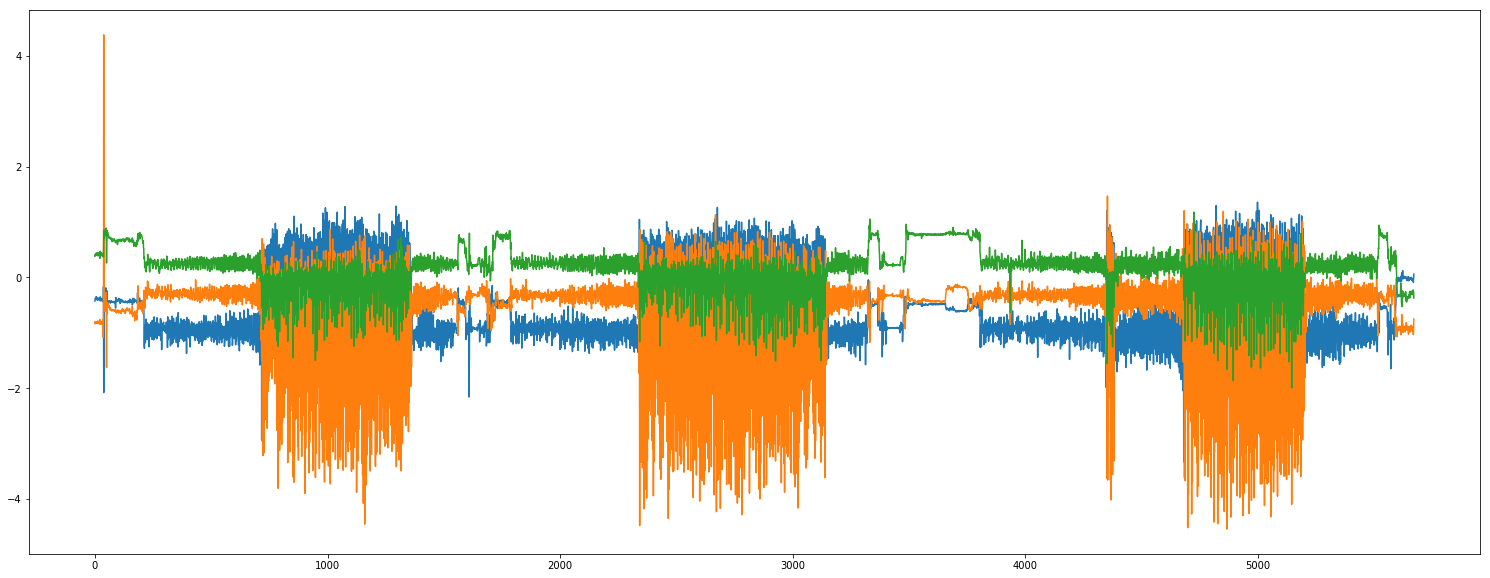

In [7]:
plt.figure(figsize=(26,10))
plt.plot(data[:,1],label="accX")
plt.plot(data[:,2],label="accY")
plt.plot(data[:,3],label="accZ")
plt.show()

In [8]:
import scipy.signal
def band_pass_filter(acc_xyz, low_freq, acc_sampling_freq):
    nyquist_limit = acc_sampling_freq / 2
    high_pass_freq = low_freq/nyquist_limit
    b, a = scipy.signal.butter(10, high_pass_freq, 'highpass')
    ft_accx = scipy.signal.filtfilt (b, a, acc_xyz[:, 0])
    ft_accy = scipy.signal.filtfilt (b, a, acc_xyz[:, 1])
    ft_accz = scipy.signal.filtfilt (b, a, acc_xyz[:, 2])
    
    ft_accx = ft_accx.reshape((ft_accx.shape[0], 1))
    ft_accy = ft_accy.reshape( (ft_accy.shape[0]), 1 )
    ft_accz = ft_accz.reshape( (ft_accz.shape[0]), 1 )
    return np.hstack( (np.hstack((ft_accx, ft_accy)), ft_accz) )

In [9]:
acc_ft = band_pass_filter(data[:,[1,2,3]],0.5,8)

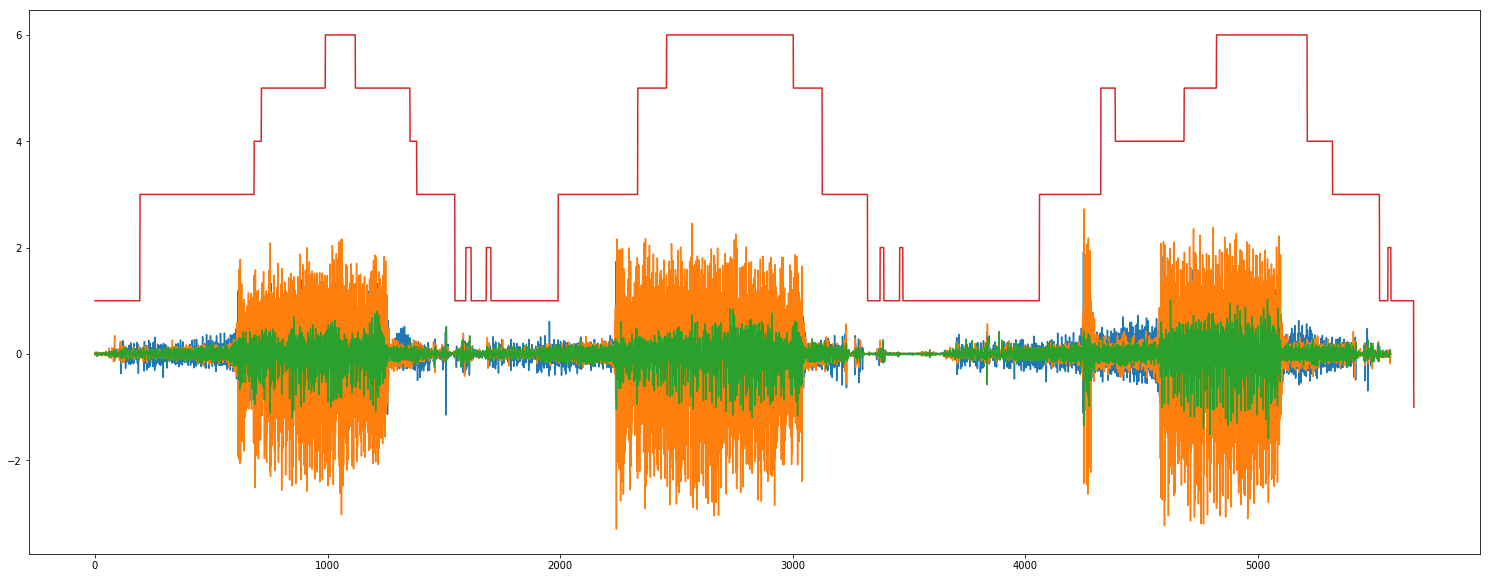

In [13]:
plt.figure(figsize=(26,10))
plt.plot(acc_ft[100:,0],label="accX")
plt.plot(acc_ft[100:,1],label="accY")
plt.plot(acc_ft[100:,2],label="accZ")
plt.plot(data[:,-1], label="output")
plt.show()

In [111]:
import math
DATA_ = "chetan.."
class window_iterator:
    def __init__(self, data, window_length, stepsize, len_axis=0, data_axis=-1):
        print("WINDOW LENGTH:----->>>>")
        print(window_length)
        print("STEP SIZE:------->>>>>>")
        print(stepsize)
        self.data = data
        self.window_length = window_length
        self.stepsize = stepsize
        self.start = 0
        self.len = self.data.shape[len_axis]
        self.len_axis = len_axis
        self.data_axis = data_axis
        self.num_windows_given = 0
        num_dimensions = len(data.shape)
        if self.data_axis < 0:
            self.data_axis = num_dimensions + self.data_axis
    
    def total_windows(self):
        print("In windows iterator...")
        print("data shape is %d"%self.data.shape[self.len_axis])
        return int( math.ceil((self.data.shape[self.len_axis])/self.stepsize))
    
    def __next__(self):
        if self.start + self.stepsize >= self.len:
            raise StopIteration
        if self.data_axis == 0:
            required_data = self.data[self.start:self.start+self.window_length, :]
        else:
            required_data = self.data[:, self.start:self.start+self.window_length]
        self.start = self.start + self.stepsize
        self.num_windows_given += 1
        return required_data
    
    def __iter__(self):
        return self

def freatures_extraction(data, y=None, window_sec=5, step_sec=1, sampling_freq=32, num_signals = 3, features_def = None, config = {} ):
    if features_def is None:
        return None
    if y is None:
        y = np.zeros(shape=(data.shape[0],1))
    data = np.hstack( (data, y) )
    print("num signals is %d"%num_signals)
    print('------------------------')
    print("Feature class Name")
    for cls in features_def:
        print(cls.__name__)
    print("-----------------------")
    window_size = window_sec * sampling_freq
    step_size = step_sec * sampling_freq
    print("in features...")
    print("data shape is %d"%data.shape[0])
    w_iter = window_iterator(data, int(window_size), int(step_size), len_axis=0, data_axis=0)
    #features_def = [mean_f, variance_f, IAV_f, maximum_f, minimum_f, abs_max_diff_min, kurtosis_f, skew_f]
    features_def_instance = [feature(num_signals, config) for feature in features_def]
    num_features  = 0
    for feature_instance in features_def_instance:
        num_features += len(feature_instance)

    headers = [label for feature_instance in features_def_instance for label in feature_instance.description_values()]
    total_windows = w_iter.total_windows()+1
    index = 0
    #num_features + 1 is to store regression or classification value
    print("total window is %f"%total_windows)
    print("total features is %f"%(num_features+1))
    features_data = np.zeros(shape=(total_windows,num_features+1))
    index = 0
    # in this I will last column is regression or classification variable
    num_iterations = 0
    for index, w_data in enumerate(w_iter):
        num_iterations += 1
        try:
            counts = np.bincount(np.array(w_data[:,-1], dtype='int64'))
        except:
            print("vikram...aditya......")
            global DATA_
            DATA_ = w_data
            raise
        hr_rate =np.argmax(counts)
        feature_index = 0
        for feature_instance in features_def_instance:
            features_data[index, feature_index:feature_index+len(feature_instance)] = feature_instance.get_values(w_data[:,:-1])
            feature_index = feature_index + len(feature_instance)
        features_data[index, num_features] = hr_rate
        index += 1
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    print(num_iterations)
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    return features_data[:index,:], headers


class Feature:
    def __init__(self, numsignals, config):
        self.numsignals = numsignals
        self.config = config
        
    def __len__(self):
        return self.numsignals

class Energy_spectrum_Feature(Feature):
    def __init__(self, num_signals, config):
        Feature.__init__(self, num_signals, config)
    
    def get_values(self, data):
        power = np.abs(np.fft.fft(data, axis = 0))
        power = power[0:int(len(power)/2), :]
        return np.sum(power, axis = 0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ['enrgy_%s'%i for i in desc]
    
    
class Principal_Frequency_Feature(Feature):
    
    def __init__(self, num_signals, config):
        Feature.__init__(self, num_signals, config)
    
    def __len__(self):
        return self.config["P_F_top"] * self.numsignals
    
    def get_values(self, data):
        power = np.abs(np.fft.fft(data, axis = 0))
        power = power[0:int(len(power)/2), :]
        sampling_freq = self.config['sampling_freq']
        freqs = np.linspace(0, sampling_freq/2, data.shape[0])
        #for now writing on top 1
        max_indexs = np.argmax(power, axis = 0)
        return freqs[max_indexs]
    
    def description_values(self):
        lst = []
        desc = self.config['signal_desc']
        return [ 'top_frq_%d_%s'%(i+1, j) for i in range(self.config['P_F_top']) for j in desc]

    
class Normalized_Abosulte_energy_band_Feature(Feature):
    
    def __init__(self, num_signals, config):
        Feature.__init__(self, num_signals, config)
        
    def __len__(self):
        # multiplying 2 is for normalized and abosule
        return self.numsignals * 2
    
    def get_values(self, data):
        power = np.abs(np.fft.fft(data, axis = 0))
        power = power[0:int(len(power)/2), :]
        sampling_freq = self.config['sampling_freq']
        band_low_freq = self.config['band_low_freq']
        band_high_freq = self.config['band_high_freq']
        freqs = np.linspace(0, sampling_freq/2, data.shape[0])
        band_low_freq_index = np.searchsorted(freqs, band_low_freq)
        band_high_freq_index = np.searchsorted(freqs, band_high_freq)
        normalised_power = np.sum(power[band_low_freq_index:band_high_freq_index+1,:], axis = 0) / np.sum(power, axis = 0)
        abosulte_power = np.sum(power[band_low_freq:band_low_freq_index+1,:], axis = 0)
        return np.append(normalised_power, abosulte_power)
    
    def description_values(self):
        band_low_freq = self.config['band_low_freq']
        band_high_freq = self.config['band_high_freq']
        desc = self.config['signal_desc']
        lst = []
        for i in desc:
            lst.append( "nrm_frq_%d_%d_%s"%(band_low_freq, band_high_freq,i) )
        for i in desc:
            lst.append( "abs_frq_%d_%d_%s"%(band_low_freq, band_high_freq,i) )
        return lst


class Mean_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return np.mean(data, axis = 0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_mean"%i for i in desc]


class Variance_Feature(Feature):
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return np.var(data, axis = 0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_var"%i for i in desc]
    
class IAV_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
        
    def get_values(self, data):
        return np.sum(np.abs(data),axis=0) / data.shape[0]
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_IAV"%i for i in desc]
    
class Maximum_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return np.max(data, axis=0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_MAX"%i for i in desc]
    
class Minimum_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return np.min(data, axis=0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_MIN"%i for i in desc]

class Diff_Min_Max_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return np.max(data, axis=0) - np.min(data, axis=0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_diff_max_min"%i for i in desc]

class Kurtosis_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return  kurtosis(data, axis = 0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_kurtosis"%i for i in desc]
    
class Skew_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
    
    def get_values(self, data):
        return  skew(data, axis = 0)
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["%s_skew"%i for i in desc]
    
class AR_coefficients_Feature(Feature):
    
    def __init__(self, numsignals, config):
        Feature.__init__(self, numsignals, config)
        
    def __len__(self):
        return self.numsignals * config['model_order']
        
    def get_values(self, data):
        ar_params = None
        for i in range(0,data.shape[1]):
            if ar_params is None:
                ar_params = spectrum.arburg(data[:,i], config['model_order'])[0]
            else:
                temp = spectrum.arburg(data[:,i], config['model_order'])[0]
                ar_params = np.append(ar_params, temp)
        return ar_params
    
    def description_values(self):
        desc = self.config['signal_desc']
        return ["AR_MO%d_%d_%s"%(config['model_order'],i,d) for d in desc for i in range(1,config['model_order']+1)]


In [115]:
headers

['enrgy_accx',
 'enrgy_accy',
 'enrgy_accz',
 'top_frq_1_accx',
 'top_frq_1_accy',
 'top_frq_1_accz',
 'nrm_frq_1_3_accx',
 'nrm_frq_1_3_accy',
 'nrm_frq_1_3_accz',
 'abs_frq_1_3_accx',
 'abs_frq_1_3_accy',
 'abs_frq_1_3_accz',
 'accx_mean',
 'accy_mean',
 'accz_mean',
 'accx_var',
 'accy_var',
 'accz_var',
 'accx_IAV',
 'accy_IAV',
 'accz_IAV',
 'accx_MAX',
 'accy_MAX',
 'accz_MAX',
 'accx_MIN',
 'accy_MIN',
 'accz_MIN',
 'accx_diff_max_min',
 'accy_diff_max_min',
 'accz_diff_max_min',
 'accx_kurtosis',
 'accy_kurtosis',
 'accz_kurtosis',
 'accx_skew',
 'accy_skew',
 'accz_skew']

In [112]:
data[-1,:]

array([ 1.5242700e+12,  5.8349610e-02, -7.5146484e-01, -3.7280273e-01,
       -1.0000000e+00])

In [113]:
acc_ft.shape[0]/8

708.875

In [145]:
class_labels = [1,2,3,4,5,6]
final_feature_data = None
big_indexes = None
for class_label in class_labels:
    config = {}
    config['band_low_freq'] = 1
    config['band_high_freq'] = 3
    config['sampling_freq'] = 8
    config['signal_desc'] = ["accx","accy","accz"]
    config['P_F_top'] = 1
    config['model_order'] = 4
    indexes = np.argwhere(data[:,-1] == class_label)
    features_def_c = [Energy_spectrum_Feature, Principal_Frequency_Feature, Normalized_Abosulte_energy_band_Feature, Mean_Feature, Variance_Feature, IAV_Feature, Maximum_Feature, Minimum_Feature, Diff_Min_Max_Feature,Kurtosis_Feature,Skew_Feature]
    b_features_data, headers = freatures_extraction(data = acc_ft[indexes[:,0],:], y = data[indexes[:,0], -1:], features_def = features_def_c, config = config, window_sec=5,step_sec=2,sampling_freq=8)
    if final_feature_data is None:
        final_feature_data = b_features_data
    else:
        final_feature_data = np.vstack((final_feature_data, b_features_data))

num signals is 3
------------------------
Feature class Name
Energy_spectrum_Feature
Principal_Frequency_Feature
Normalized_Abosulte_energy_band_Feature
Mean_Feature
Variance_Feature
IAV_Feature
Maximum_Feature
Minimum_Feature
Diff_Min_Max_Feature
Kurtosis_Feature
Skew_Feature
-----------------------
in features...
data shape is 1438
WINDOW LENGTH:----->>>>
40
STEP SIZE:------->>>>>>
16
In windows iterator...
data shape is 1438
total window is 91.000000
total features is 37.000000
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
89
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
num signals is 3
------------------------
Feature class Name
Energy_spectrum_Feature
Principal_Frequency_Feature
Normalized_Abosulte_energy_band_Feature
Mean_Feature
Variance_Feature
IAV_Feature
Maximum_Feature
Minimum_Feature
Diff_Min_Max_Feature
Kurtosis_Feature
Skew_Feature
-----------------------
in features...
data shape is 86
WINDOW LENGTH:----->>>>
40
STEP SIZE:------->>>>>>
16
In windows iterator...

In [146]:
final_feature_data.shape

(351, 37)

In [147]:
np.savetxt('final_feature_data.csv', final_feature_data, delimiter=',')

In [148]:
with open('header.csv','w') as fp:
    fp.write(",".join(headers))